In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.metric.metric import Metric
from financial_common.risk.risk_type import RiskType
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
ori = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("cryptocurrencies")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("crypto",{"ticker":"BTC-USD"})
benchmark = p.utc_date(benchmark)
benchmark["close"] = benchmark["close"].astype(float)
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"close")

In [7]:
rolling_window = 14

In [8]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("crypto", {"ticker": ticker})
        price.rename(columns={"close":"adjclose"},inplace=True)
        for col in price.columns:
            if col not in ["date", "ticker"]:
                try:
                    price[col] = price[col].astype(float)
                    
                except Exception as e:
                    print(str(e))
                    continue
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price,timeframe=rolling_window)
            prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 24.17it/s]


In [9]:
model_end = 2023
backtest_end = 2026
simulation = pd.concat(prices)
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)
simulation.columns

Index(['start', 'low', 'high', 'open', 'adjclose', 'volume', 'ticker', 'date',
       'year', 'month', 'quarter', 'week', 'day', 'reference_price',
       'reference_volume', 'reference_high', 'reference_low', 'average_return',
       'standard_dev', 'rolling_dollar_volume', 'simple_moving_average',
       'drawdown', 'distance', 'next_close', 'optimal', 'adr', 'sma',
       'sma_corr', 'ema', 'ema_corr', 'ema_volume_corr', 'bollinger_upper',
       'bollinger_lower', 'momentum', 'roc', 'williams_r', 'obv', 'vwap',
       'market_impact', 'atr', 'coefficient_of_variation'],
      dtype='object')

In [10]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=[member.label for member in Indicator],group_percentages=[1],num_of_groups=[1],max_prices=[10],min_prices=[0.1],stoplosses=[0.05],rolling_windows=[rolling_window])
portfolios = [x for x in portfolios if x.timeframe.value == "day" and x.selection_type.label != "long_short" and x.position_type.label == "long" and x.ranking_metric != "optimal" and x.grouping_type.value == "standard_dev"]
len(portfolios)

60

In [11]:
analysises = []
for portfolio in tqdm(portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.51it/s]


In [12]:
a = pd.DataFrame(analysises)
a.columns

Index(['ranking_metric', 'timeframe', 'position_type', 'grouping_type',
       'selection_type', 'allocation_type', 'risk_type',
       'selection_percentage', 'stoploss', 'num_of_groups', 'max_price',
       'min_price', 'rolling_window', 'date', 'pnl', 'raw_pnl', 'downside',
       'coefficient_of_variation', 'portfolio_std', 'average_gain',
       'average_loss', 'win_loss_ratio', 'weekly_return', 'sharpe_ratio',
       'portfolio'],
      dtype='object')

In [13]:
a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values("pnl",ascending=False).head(20)

,ranking_metric,position_type,grouping_type,selection_type,stoploss,num_of_groups,max_price,min_price,rolling_window,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio
18,ema_corr,long,STANDARD_DEV,bottom,0.05,1,10,0.1,14,2.636693,2.897223,0.95,4.102208,0.642750,1.007260,0.972201,0.878531,1.003001,1.673147,<financial_common.portfolio_management.portfol...
21,ema_volume_corr,long,STANDARD_DEV,top,0.05,1,10,0.1,14,2.186601,2.320179,0.95,5.113786,0.427590,1.007172,0.971509,0.870056,1.002538,1.462438,<financial_common.portfolio_management.portfol...
23,ema_volume_corr,long,STANDARD_DEV,top_blacklist,0.05,1,10,0.1,14,1.764706,2.058145,0.95,6.631670,0.266103,1.006953,0.970354,0.861582,1.001887,0.764470,<financial_common.portfolio_management.portfol...
20,ema_volume_corr,long,STANDARD_DEV,mixed,0.05,1,10,0.1,14,1.755127,2.119951,0.95,5.433908,0.322995,1.006337,0.969809,0.874294,1.001745,0.600160,<financial_common.portfolio_management.portfol...
43,williams_r,long,STANDARD_DEV,top_blacklist,0.05,1,10,0.1,14,1.734121,1.975695,0.95,7.661263,0.226349,1.006493,0.972775,0.861582,1.001826,0.763611,<financial_common.portfolio_management.portfol...
16,ema_corr,long,STANDARD_DEV,mixed,0.05,1,10,0.1,14,1.473919,1.622530,0.95,7.278637,0.202499,1.006815,0.969723,0.850282,1.001261,-0.431406,<financial_common.portfolio_management.portfol...
22,ema_volume_corr,long,STANDARD_DEV,bottom,0.05,1,10,0.1,14,1.467970,1.755550,0.95,4.822322,0.304411,1.005961,0.967990,0.878531,1.001349,-0.306520,<financial_common.portfolio_management.portfol...
13,ema,long,STANDARD_DEV,top,0.05,1,10,0.1,14,1.417773,1.603833,0.95,8.297985,0.170857,1.006977,0.968032,0.853107,1.001256,-0.839912,<financial_common.portfolio_management.portfol...
12,ema,long,STANDARD_DEV,mixed,0.05,1,10,0.1,14,1.302928,1.488180,0.95,10.225654,0.127418,1.006349,0.968523,0.855932,1.000900,-2.027589,<financial_common.portfolio_management.portfol...
55,market_impact,long,STANDARD_DEV,top_blacklist,0.05,1,10,0.1,14,1.293949,1.503181,0.95,10.241755,0.126341,1.004073,0.975764,0.887006,1.000874,-2.115938,<financial_common.portfolio_management.portfol...


In [14]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

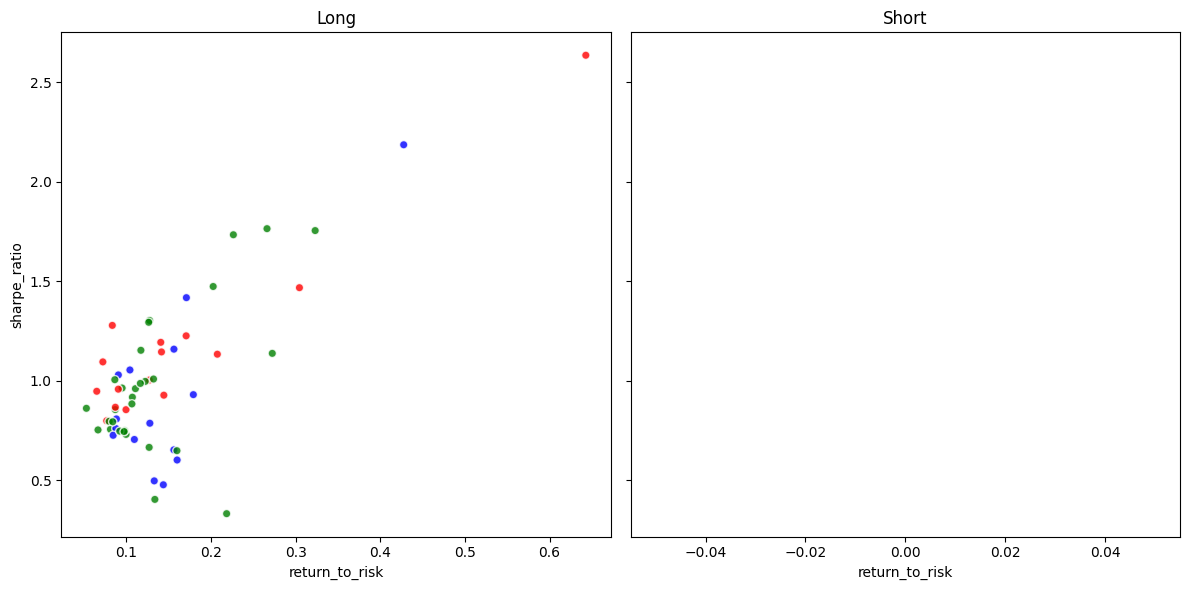

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [16]:
top = a[(a["timeframe"]=="DAY") & (a["ranking_metric"]!="optimal")].sort_values("pnl",ascending=False).to_dict("records")[0]
top

{'ranking_metric': 'ema_corr',
 'timeframe': 'DAY',
 'position_type': 'long',
 'grouping_type': 'STANDARD_DEV',
 'selection_type': 'bottom',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 1,
 'stoploss': 0.05,
 'num_of_groups': 1,
 'max_price': 10,
 'min_price': 0.1,
 'rolling_window': 14,
 'date': Timestamp('2025-05-19 00:00:00+0000', tz='UTC'),
 'pnl': 2.6366931456133362,
 'raw_pnl': 2.897223075505858,
 'downside': 0.95,
 'coefficient_of_variation': 4.1022076317475245,
 'portfolio_std': 0.6427498026203309,
 'average_gain': 1.0072597735369722,
 'average_loss': 0.9722009592919965,
 'win_loss_ratio': 0.8785310734463276,
 'weekly_return': 1.0030012170043903,
 'sharpe_ratio': 1.6731473219684374,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x1a7d6e2a490>,
 'color': 'red',
 'return_to_risk': 4.1022076317475245}

In [17]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

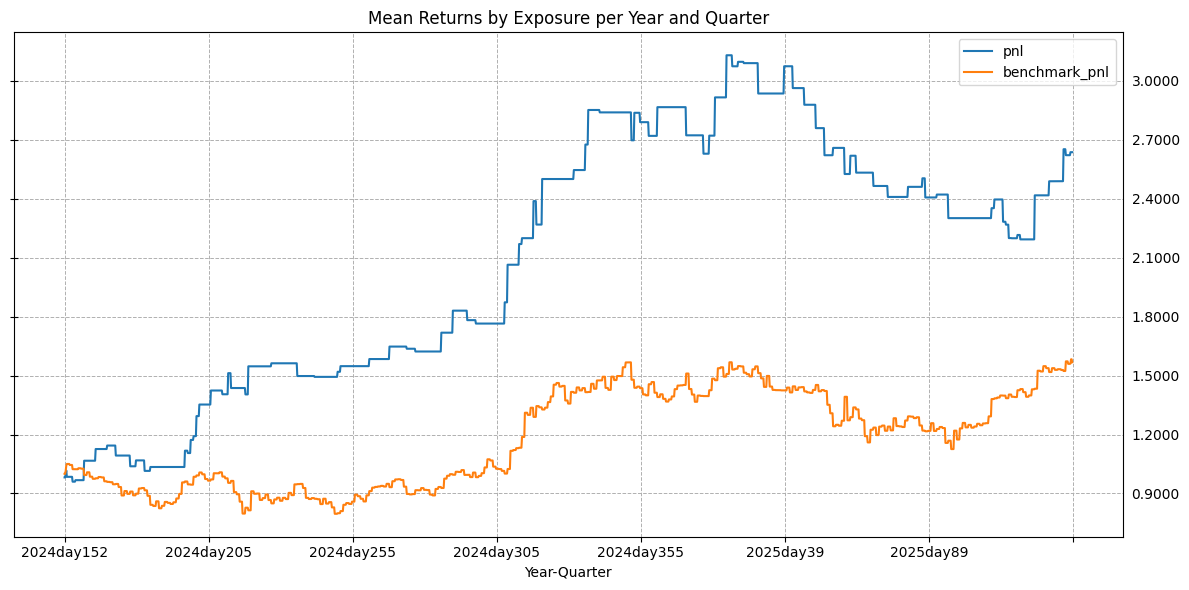

In [18]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + pm.timeframe.value + portfolio[pm.timeframe.value].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [19]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
POL-USD,1.008939
ICP-USD,1.008901
SAND-USD,1.006653
UNI-USD,1.005712
HNT-USD,1.004090
MATIC-USD,1.003581
WIF-USD,1.003358
DOGE-USD,1.003063
ATOM-USD,1.001588


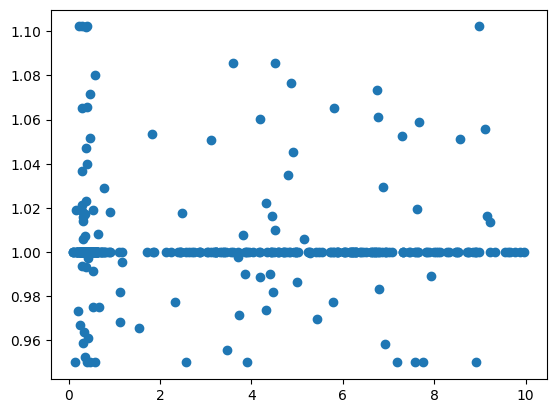

In [20]:
plt.scatter(trades["adjclose"],trades["return"])
plt.show()

In [21]:
ori.cloud_connect()
ori.drop("crypto_results")
ori.store("crypto_results",pd.DataFrame([top]).drop("portfolio",axis=1))
ori.disconnect()